In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sm
data1 = np.load('/Users/diana/Documents/Project/all/train-1.npy')
data2 = np.load('/Users/diana/Documents/Project/all/train-2.npy')
data3 = np.load('/Users/diana/Documents/Project/all/train-3.npy')
data4 = np.load('/Users/diana/Documents/Project/all/train-4.npy')
data = np.concatenate((data1, data2, data3, data4), axis = 0)
np.random.shuffle(data)

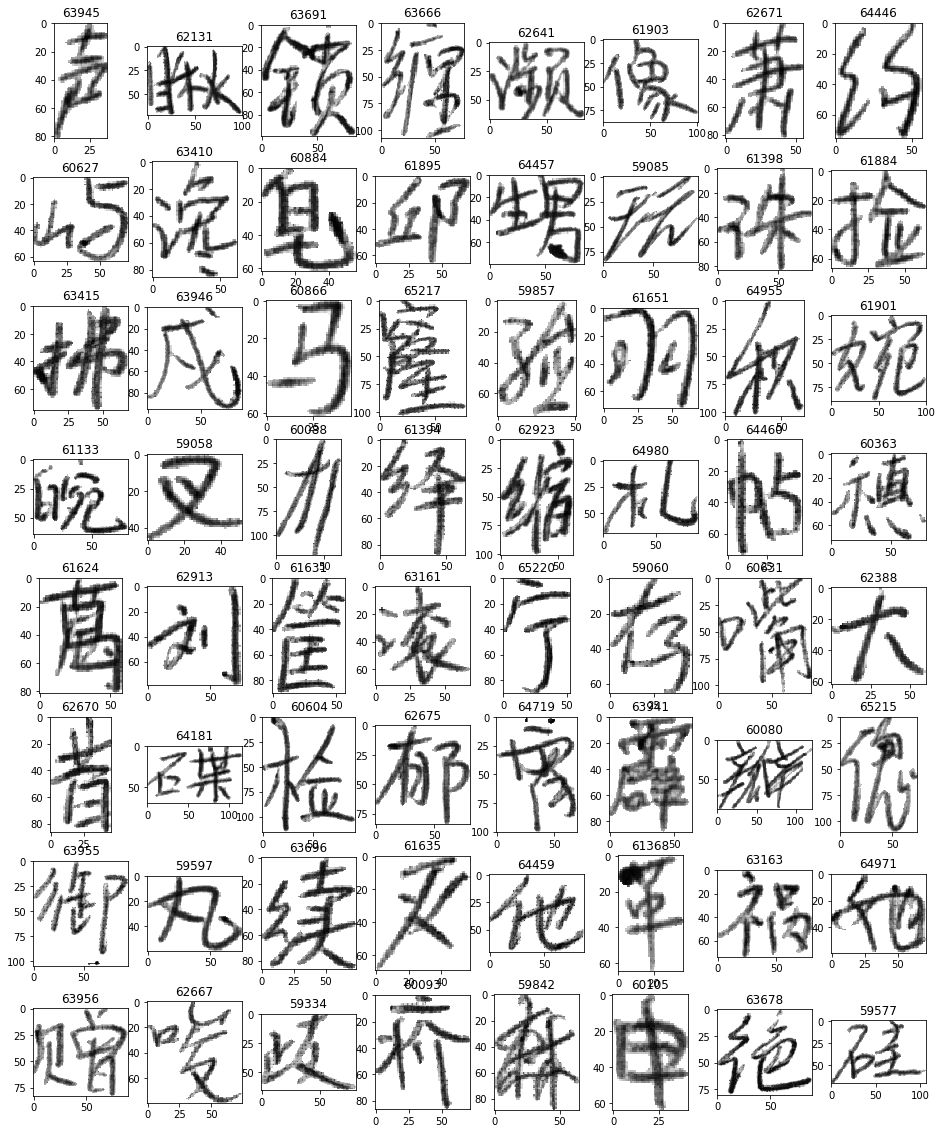

In [2]:
width, height = 8, 8

plt.figure(figsize=(16, 20))
for n, (image, tag) in enumerate(data, 1):
    if n > width * height:
        break
    plt.subplot(height, width, n)
    plt.title(tag)
    plt.imshow(image, cmap='gray')
plt.show()

In [3]:
def make_data():
    amount = 0
    code_to_num = {}
    num_to_code = {}
    data_x = []
    data_y = []
    k = 0
    for el in data:
        data_x.append(255 - sm.imresize(el[0], (50, 50)))
        cod = el[1]
        if cod in code_to_num:
            data_y.append(code_to_num.get(cod))
        else:
            data_y.append(amount)
            code_to_num[cod] = amount
            num_to_code[amount] = cod
            amount += 1
        k += 1
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    data_x = torch.from_numpy(data_x).float()
    data_y = torch.from_numpy(data_y).long()
    return data_x, data_y, code_to_num, num_to_code

In [4]:
data_x, data_y, code_to_num, num_to_code = make_data()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


In [13]:
part = 1/10;
N = data_x.shape[0]
first_part = int((1 - part) * N)
train_x = data_x[:first_part]
train_y = data_y[:first_part]
test_x = data_x[first_part:]
test_y = data_y[first_part:]

batch_size = 10
train_Dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)

test_Dataset = torch.utils.data.TensorDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_Dataset, batch_size=batch_size, shuffle=True)



In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc3 = nn.Linear(16 * 9 * 9, 120)
        self.fc1 = nn.Linear(120, 600)
        self.fc2 = nn.Linear(600, 1000)
        
    def forward(self, x):
        x = x.view(-1, 1, 50, 50)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 9 * 9)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [31]:
model = Net()

In [36]:

optimizer = optim.SGD(model.parameters(), lr=0.001)
train_accuracy_epoch = []
test_accuracy_epoch = []

In [37]:
def train(epoch, model=model):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
#     else:
#         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#             epoch, batch_idx * len(data), len(train_loader.dataset),
#             100. * batch_idx / len(train_loader), loss.data.item()))

In [38]:
def test(log=None, model=model):
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_correct_percent = 100. * test_correct / len(test_loader.dataset)
        test_accuracy_epoch.append(test_correct_percent)

        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            train_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            train_correct += pred.eq(target.data.view_as(pred)).sum()
        train_loss /= len(train_loader.dataset)
        train_correct_percent = 100. * train_correct / len(train_loader.dataset)
        train_accuracy_epoch.append(train_correct_percent)
        
    print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, test_correct, len(test_loader.dataset), test_correct_percent))
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset), train_correct_percent))

In [39]:
epoch_num = 10
for epoch in range(1, epoch_num):
    train(epoch, model)
    test(' ', model)

Train Epoch: 1 [0/299688 (0%)]	Loss: 0.405295
Train Epoch: 1 [2000/299688 (1%)]	Loss: 0.617696
Train Epoch: 1 [4000/299688 (1%)]	Loss: 0.013651
Train Epoch: 1 [6000/299688 (2%)]	Loss: 0.490046
Train Epoch: 1 [8000/299688 (3%)]	Loss: 0.290080
Train Epoch: 1 [10000/299688 (3%)]	Loss: 0.628629
Train Epoch: 1 [12000/299688 (4%)]	Loss: 0.202585
Train Epoch: 1 [14000/299688 (5%)]	Loss: 0.082776
Train Epoch: 1 [16000/299688 (5%)]	Loss: 0.002327
Train Epoch: 1 [18000/299688 (6%)]	Loss: 0.398311
Train Epoch: 1 [20000/299688 (7%)]	Loss: 0.404535
Train Epoch: 1 [22000/299688 (7%)]	Loss: 0.803787
Train Epoch: 1 [24000/299688 (8%)]	Loss: 0.642977
Train Epoch: 1 [26000/299688 (9%)]	Loss: 1.041935
Train Epoch: 1 [28000/299688 (9%)]	Loss: 0.021055
Train Epoch: 1 [30000/299688 (10%)]	Loss: 1.082843
Train Epoch: 1 [32000/299688 (11%)]	Loss: 0.041737
Train Epoch: 1 [34000/299688 (11%)]	Loss: 0.579993
Train Epoch: 1 [36000/299688 (12%)]	Loss: 1.658859
Train Epoch: 1 [38000/299688 (13%)]	Loss: 0.194092
Tra

Train Epoch: 2 [14000/299688 (5%)]	Loss: 0.010708
Train Epoch: 2 [16000/299688 (5%)]	Loss: 0.102853
Train Epoch: 2 [18000/299688 (6%)]	Loss: 0.206640
Train Epoch: 2 [20000/299688 (7%)]	Loss: 0.014119
Train Epoch: 2 [22000/299688 (7%)]	Loss: 0.512304
Train Epoch: 2 [24000/299688 (8%)]	Loss: 0.019423
Train Epoch: 2 [26000/299688 (9%)]	Loss: 0.034352
Train Epoch: 2 [28000/299688 (9%)]	Loss: 0.303448
Train Epoch: 2 [30000/299688 (10%)]	Loss: 0.131592
Train Epoch: 2 [32000/299688 (11%)]	Loss: 0.041560
Train Epoch: 2 [34000/299688 (11%)]	Loss: 0.024094
Train Epoch: 2 [36000/299688 (12%)]	Loss: 0.033389
Train Epoch: 2 [38000/299688 (13%)]	Loss: 0.277369
Train Epoch: 2 [40000/299688 (13%)]	Loss: 0.025436
Train Epoch: 2 [42000/299688 (14%)]	Loss: 0.116257
Train Epoch: 2 [44000/299688 (15%)]	Loss: 0.100693
Train Epoch: 2 [46000/299688 (15%)]	Loss: 0.008552
Train Epoch: 2 [48000/299688 (16%)]	Loss: 0.070152
Train Epoch: 2 [50000/299688 (17%)]	Loss: 0.018803
Train Epoch: 2 [52000/299688 (17%)]	Los

Train Epoch: 3 [28000/299688 (9%)]	Loss: 0.028390
Train Epoch: 3 [30000/299688 (10%)]	Loss: 0.001438
Train Epoch: 3 [32000/299688 (11%)]	Loss: 0.191492
Train Epoch: 3 [34000/299688 (11%)]	Loss: 0.031043
Train Epoch: 3 [36000/299688 (12%)]	Loss: 0.139774
Train Epoch: 3 [38000/299688 (13%)]	Loss: 0.032159
Train Epoch: 3 [40000/299688 (13%)]	Loss: 0.094960
Train Epoch: 3 [42000/299688 (14%)]	Loss: 0.018747
Train Epoch: 3 [44000/299688 (15%)]	Loss: 0.284612
Train Epoch: 3 [46000/299688 (15%)]	Loss: 0.034551
Train Epoch: 3 [48000/299688 (16%)]	Loss: 0.021507
Train Epoch: 3 [50000/299688 (17%)]	Loss: 0.375726
Train Epoch: 3 [52000/299688 (17%)]	Loss: 0.182618
Train Epoch: 3 [54000/299688 (18%)]	Loss: 0.034139
Train Epoch: 3 [56000/299688 (19%)]	Loss: 0.048922
Train Epoch: 3 [58000/299688 (19%)]	Loss: 0.000568
Train Epoch: 3 [60000/299688 (20%)]	Loss: 0.078659
Train Epoch: 3 [62000/299688 (21%)]	Loss: 0.004216
Train Epoch: 3 [64000/299688 (21%)]	Loss: 0.306203
Train Epoch: 3 [66000/299688 (22

Train Epoch: 4 [42000/299688 (14%)]	Loss: 0.000222
Train Epoch: 4 [44000/299688 (15%)]	Loss: 0.819802
Train Epoch: 4 [46000/299688 (15%)]	Loss: 0.005054
Train Epoch: 4 [48000/299688 (16%)]	Loss: 0.093159
Train Epoch: 4 [50000/299688 (17%)]	Loss: 0.011688
Train Epoch: 4 [52000/299688 (17%)]	Loss: 0.042455
Train Epoch: 4 [54000/299688 (18%)]	Loss: 0.002757
Train Epoch: 4 [56000/299688 (19%)]	Loss: 0.006042
Train Epoch: 4 [58000/299688 (19%)]	Loss: 0.025278
Train Epoch: 4 [60000/299688 (20%)]	Loss: 0.105594
Train Epoch: 4 [62000/299688 (21%)]	Loss: 0.049468
Train Epoch: 4 [64000/299688 (21%)]	Loss: 0.036458
Train Epoch: 4 [66000/299688 (22%)]	Loss: 0.054384
Train Epoch: 4 [68000/299688 (23%)]	Loss: 0.000366
Train Epoch: 4 [70000/299688 (23%)]	Loss: 0.021121
Train Epoch: 4 [72000/299688 (24%)]	Loss: 0.026733
Train Epoch: 4 [74000/299688 (25%)]	Loss: 0.025185
Train Epoch: 4 [76000/299688 (25%)]	Loss: 0.054809
Train Epoch: 4 [78000/299688 (26%)]	Loss: 0.017100
Train Epoch: 4 [80000/299688 (2

Train Epoch: 5 [56000/299688 (19%)]	Loss: 0.015002
Train Epoch: 5 [58000/299688 (19%)]	Loss: 0.115027
Train Epoch: 5 [60000/299688 (20%)]	Loss: 0.002699
Train Epoch: 5 [62000/299688 (21%)]	Loss: 0.002066
Train Epoch: 5 [64000/299688 (21%)]	Loss: 0.067020
Train Epoch: 5 [66000/299688 (22%)]	Loss: 0.000361
Train Epoch: 5 [68000/299688 (23%)]	Loss: 0.110678
Train Epoch: 5 [70000/299688 (23%)]	Loss: 0.007500
Train Epoch: 5 [72000/299688 (24%)]	Loss: 0.030642
Train Epoch: 5 [74000/299688 (25%)]	Loss: 0.013435
Train Epoch: 5 [76000/299688 (25%)]	Loss: 0.023201
Train Epoch: 5 [78000/299688 (26%)]	Loss: 0.000991
Train Epoch: 5 [80000/299688 (27%)]	Loss: 0.002492
Train Epoch: 5 [82000/299688 (27%)]	Loss: 0.000274
Train Epoch: 5 [84000/299688 (28%)]	Loss: 0.395795
Train Epoch: 5 [86000/299688 (29%)]	Loss: 0.244580
Train Epoch: 5 [88000/299688 (29%)]	Loss: 0.388067
Train Epoch: 5 [90000/299688 (30%)]	Loss: 0.002706
Train Epoch: 5 [92000/299688 (31%)]	Loss: 0.011266
Train Epoch: 5 [94000/299688 (3

Train Epoch: 6 [70000/299688 (23%)]	Loss: 0.000734
Train Epoch: 6 [72000/299688 (24%)]	Loss: 0.002603
Train Epoch: 6 [74000/299688 (25%)]	Loss: 0.000785
Train Epoch: 6 [76000/299688 (25%)]	Loss: 0.009513
Train Epoch: 6 [78000/299688 (26%)]	Loss: 0.003030
Train Epoch: 6 [80000/299688 (27%)]	Loss: 0.019489
Train Epoch: 6 [82000/299688 (27%)]	Loss: 0.000045
Train Epoch: 6 [84000/299688 (28%)]	Loss: 0.002570
Train Epoch: 6 [86000/299688 (29%)]	Loss: 0.000061
Train Epoch: 6 [88000/299688 (29%)]	Loss: 0.053936
Train Epoch: 6 [90000/299688 (30%)]	Loss: 0.000166
Train Epoch: 6 [92000/299688 (31%)]	Loss: 0.000165
Train Epoch: 6 [94000/299688 (31%)]	Loss: 0.076576
Train Epoch: 6 [96000/299688 (32%)]	Loss: 0.002712
Train Epoch: 6 [98000/299688 (33%)]	Loss: 0.000539
Train Epoch: 6 [100000/299688 (33%)]	Loss: 0.040254
Train Epoch: 6 [102000/299688 (34%)]	Loss: 0.018037
Train Epoch: 6 [104000/299688 (35%)]	Loss: 0.064239
Train Epoch: 6 [106000/299688 (35%)]	Loss: 0.004312
Train Epoch: 6 [108000/2996

Train Epoch: 7 [84000/299688 (28%)]	Loss: 0.000079
Train Epoch: 7 [86000/299688 (29%)]	Loss: 0.005130
Train Epoch: 7 [88000/299688 (29%)]	Loss: 0.000632
Train Epoch: 7 [90000/299688 (30%)]	Loss: 0.000209
Train Epoch: 7 [92000/299688 (31%)]	Loss: 0.031272
Train Epoch: 7 [94000/299688 (31%)]	Loss: 0.001377
Train Epoch: 7 [96000/299688 (32%)]	Loss: 0.004186
Train Epoch: 7 [98000/299688 (33%)]	Loss: 0.408413
Train Epoch: 7 [100000/299688 (33%)]	Loss: 0.051832
Train Epoch: 7 [102000/299688 (34%)]	Loss: 0.007019
Train Epoch: 7 [104000/299688 (35%)]	Loss: 0.002242
Train Epoch: 7 [106000/299688 (35%)]	Loss: 0.021854
Train Epoch: 7 [108000/299688 (36%)]	Loss: 0.000089
Train Epoch: 7 [110000/299688 (37%)]	Loss: 0.012055
Train Epoch: 7 [112000/299688 (37%)]	Loss: 0.010893
Train Epoch: 7 [114000/299688 (38%)]	Loss: 0.008040
Train Epoch: 7 [116000/299688 (39%)]	Loss: 0.033756
Train Epoch: 7 [118000/299688 (39%)]	Loss: 0.013034
Train Epoch: 7 [120000/299688 (40%)]	Loss: 0.002911
Train Epoch: 7 [1220

Train Epoch: 8 [98000/299688 (33%)]	Loss: 0.030645
Train Epoch: 8 [100000/299688 (33%)]	Loss: 0.019319
Train Epoch: 8 [102000/299688 (34%)]	Loss: 0.008438
Train Epoch: 8 [104000/299688 (35%)]	Loss: 0.006027
Train Epoch: 8 [106000/299688 (35%)]	Loss: 0.003160
Train Epoch: 8 [108000/299688 (36%)]	Loss: 0.004988
Train Epoch: 8 [110000/299688 (37%)]	Loss: 0.033992
Train Epoch: 8 [112000/299688 (37%)]	Loss: 0.026365
Train Epoch: 8 [114000/299688 (38%)]	Loss: 0.000151
Train Epoch: 8 [116000/299688 (39%)]	Loss: 0.000072
Train Epoch: 8 [118000/299688 (39%)]	Loss: 0.000172
Train Epoch: 8 [120000/299688 (40%)]	Loss: 0.002623
Train Epoch: 8 [122000/299688 (41%)]	Loss: 0.012280
Train Epoch: 8 [124000/299688 (41%)]	Loss: 0.000381
Train Epoch: 8 [126000/299688 (42%)]	Loss: 0.002868
Train Epoch: 8 [128000/299688 (43%)]	Loss: 0.000609
Train Epoch: 8 [130000/299688 (43%)]	Loss: 0.000758
Train Epoch: 8 [132000/299688 (44%)]	Loss: 0.012536
Train Epoch: 8 [134000/299688 (45%)]	Loss: 0.008920
Train Epoch: 

KeyboardInterrupt: 

In [40]:
test = np.load('/Users/diana/Documents/Project/all/test.npy')


In [41]:
data_x = []
for el in test:
    data_x.append(255 - sm.imresize(el, (50, 50)))
data_x = np.array(data_x)
data_x = torch.from_numpy(data_x).float()


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
output = model(data_x)
pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability

In [43]:
for i in range(pred.shape[0]):
    pred[i] = num_to_code.get(pred[i].item())

In [44]:
pred = pred.numpy()

In [45]:
y = np.arange(pred.shape[0], dtype = int) + 1
y = y.reshape((y.shape[0], 1))
ans = np.concatenate((y, pred), axis = 1)
first = np.array([0, 0]).reshape((1, 2))
ans = np.concatenate((first, ans), axis = 0)
print(type(ans[0][0]))
np.savetxt("ans2.csv", ans, delimiter=",", fmt = '%d')

<class 'numpy.int64'>
